# imports

In [1]:
import pandas as pd
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt; plt.rcParams['font.family'] = 'Malgun Gothic'
import seaborn as sns; sns.set(font='Malgun Gothic')

import warnings; warnings.filterwarnings(action='ignore')
pd.set_option('display.max_rows', 100, 'display.max_columns', 100, 'max_colwidth', None)

from pycaret.regression import *

# read

In [2]:
train = pd.read_csv('./input/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
test  = pd.read_csv('./input/test.csv')
sub   = pd.read_csv('./input/sample_submission.csv')
temp  = pd.read_csv('./input/STCS_우리나라기후평년값_DD_20211026151605.csv') # 2001 ~ 2010년 일별 기후평년값
# https://data.kma.go.kr/climate/average30Years/selectAverage30YearsKoreaList.do?pgmNo=188

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   연월일     368088 non-null  object 
 1   시간      368088 non-null  int64  
 2   구분      368088 non-null  object 
 3   공급량     368088 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 11.2+ MB


In [4]:
train.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


In [5]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


# test data preprocess

In [6]:
test['연월일'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간']  = test['일자|시간|구분'].str.split(' ').str[1].astype('int')
test['구분']  = test['일자|시간|구분'].str.split(' ').str[2]

test.drop('일자|시간|구분', axis=1, inplace=True)

In [7]:
test.head()

,연월일,시간,구분
0,2019-01-01,1,A
1,2019-01-01,2,A
2,2019-01-01,3,A
3,2019-01-01,4,A
4,2019-01-01,5,A


# temp

In [8]:
temp.head()

,지점명,지점번호,일시,평균기온(°C),최고기온(°C),최저기온(°C),강수량(mm),습도(%),일조시간(hr),전운량(1/10),소형증발량(mm),현지기압(hPa),해면기압(hPa),평균풍속(m/sec)
0,속초,90,01-01,-0.6,3.4,-4.3,0.5,39.8,6.2,NaN,NaN,1017.3,1019.6,NaN
1,철원,95,01-01,-6.6,-0.6,-12.7,0.6,66.5,5.5,NaN,NaN,1003.7,1023.6,NaN
2,동두천,98,01-01,-4.9,0.9,-10.1,0.5,60.9,5.5,NaN,NaN,1009.0,1023.5,NaN
3,파주,99,01-01,-5.0,0.8,-10.9,0.2,65.4,5.8,NaN,NaN,1019.9,1023.8,NaN
4,대관령,100,01-01,-7.7,-2.7,-12.6,0.6,65.8,6.6,NaN,NaN,920.7,1020.9,NaN


In [9]:
temp.dropna(axis=1, how='any', inplace=True)
temp.rename({})

,지점명,지점번호,일시,평균기온(°C),최고기온(°C),최저기온(°C),강수량(mm)
0,속초,90,01-01,-0.6,3.4,-4.3,0.5
1,철원,95,01-01,-6.6,-0.6,-12.7,0.6
2,동두천,98,01-01,-4.9,0.9,-10.1,0.5
3,파주,99,01-01,-5.0,0.8,-10.9,0.2
4,대관령,100,01-01,-7.7,-2.7,-12.6,0.6
...,...,...,...,...,...,...,...
76855,부산진,938,12-31,1.9,5.8,-1.7,0.0
76856,동래,940,12-31,2.7,7.0,-1.2,0.0
76857,북구,941,12-31,1.4,5.7,-2.4,0.1
76858,부산남구,942,12-31,2.8,6.8,-1.1,0.0


In [10]:
temp.head()

,지점명,지점번호,일시,평균기온(°C),최고기온(°C),최저기온(°C),강수량(mm)
0,속초,90,01-01,-0.6,3.4,-4.3,0.5
1,철원,95,01-01,-6.6,-0.6,-12.7,0.6
2,동두천,98,01-01,-4.9,0.9,-10.1,0.5
3,파주,99,01-01,-5.0,0.8,-10.9,0.2
4,대관령,100,01-01,-7.7,-2.7,-12.6,0.6


In [11]:
temp['일시'].max(), temp['일시'].min()

('12-31', '01-01')

In [12]:
temp = temp.groupby('일시').mean()
temp.drop('지점번호', axis=1, inplace=True)
temp

,평균기온(°C),최고기온(°C),최저기온(°C),강수량(mm)
일시,,,,
01-01,-1.348095,3.390952,-5.760000,0.444762
01-02,-1.238095,3.580476,-5.614762,0.463333
01-03,-1.255714,3.718095,-5.735238,0.374762
01-04,-1.260000,3.876190,-5.880476,0.401905
01-05,-1.423333,3.754286,-6.000476,0.726190
01-06,-1.721905,3.555714,-6.266667,0.758095
01-07,-1.728095,3.617143,-6.438095,0.722381
01-08,-1.426667,3.844286,-6.094286,0.708571
01-09,-1.250000,3.942381,-5.764286,0.902857


# temp pca

In [13]:
from sklearn.decomposition import PCA

temp_pca = PCA(n_components=1)
pca_cols = ['평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '강수량(mm)']
temp_pca.fit(temp[pca_cols])

temp_pca.explained_variance_ratio_

array([0.97560316])

In [14]:
temp['temp_pca'] = temp_pca.transform(temp[pca_cols])
temp.drop(pca_cols, axis=1, inplace=True)

In [15]:
temp.head()

,temp_pca
일시,
01-01,25.023228
01-02,24.767818
01-03,24.788009
01-04,24.783260
01-05,24.955461


# merge temp

In [16]:
train['일시'] = train['연월일'].str[5:]
test['일시']  = test['연월일'].str[5:]

In [17]:
train = pd.merge(train, temp, how='left', on='일시')
test  = pd.merge(test, temp, how='left', on='일시')

train.drop('일시', axis=1, inplace=True)
test.drop('일시', axis=1, inplace=True)

# EDA

In [18]:
# sns.relplot(
#     data=total, x='연월일', y='공급량', 
#     hue='시간', col='구분', col_wrap=1, 
#     height=5, aspect=3
# ); plt.show()

<img src='./eda/gas_demand_relplot.png'>

In [19]:
# sns.relplot(
#     data=total[total['구분'] == 'D'], x='연월일', y='공급량', 
#     hue='시간', 
#     height=5, aspect=3, kind='line'
# ); plt.show()

<img src='./eda/gas_demand_relplot_d.png'>

# preprocessing

## target encoding

In [20]:
train['구분'].value_counts()

A    52584
B    52584
C    52584
D    52584
E    52584
G    52584
H    52584
Name: 구분, dtype: int64

In [21]:
test['구분'].value_counts()

A    2160
B    2160
C    2160
D    2160
E    2160
G    2160
H    2160
Name: 구분, dtype: int64

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train['구분'])
train['구분'] = le.transform(train['구분'])
test['구분']  = le.transform(test['구분'])

In [23]:
train['구분'].value_counts()

0    52584
1    52584
2    52584
3    52584
4    52584
5    52584
6    52584
Name: 구분, dtype: int64

In [24]:
test['구분'].value_counts()

0    2160
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
Name: 구분, dtype: int64

## datetime

In [25]:
train['연월일'] = pd.to_datetime(train['연월일'])
test['연월일']  = pd.to_datetime(test['연월일'])

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368088 entries, 0 to 368087
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   연월일       368088 non-null  datetime64[ns]
 1   시간        368088 non-null  int64         
 2   구분        368088 non-null  int32         
 3   공급량       368088 non-null  float64       
 4   temp_pca  368088 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 15.4 MB


In [27]:
train['year']    = train['연월일'].dt.year
train['month']   = train['연월일'].dt.month
train['day']     = train['연월일'].dt.day
train['weekday'] = train['연월일'].dt.weekday
train['quarter'] = train['연월일'].dt.quarter
train['weekofyear'] = train['연월일'].dt.weekofyear

In [28]:
test['year']    = test['연월일'].dt.year
test['month']   = test['연월일'].dt.month
test['day']     = test['연월일'].dt.day
test['weekday'] = test['연월일'].dt.weekday
test['quarter'] = test['연월일'].dt.quarter
test['weekofyear'] = test['연월일'].dt.weekofyear

<AxesSubplot:xlabel='temp_pca', ylabel='공급량'>

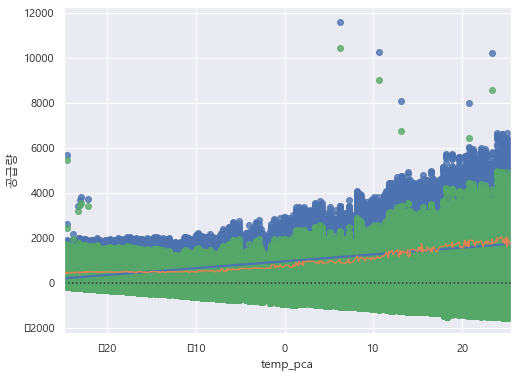

In [29]:
plt.subplots(figsize=(8, 6))
sns.regplot(data=train, x='temp_pca', y='공급량')
sns.lineplot(data=train, x='temp_pca', y='공급량')
sns.residplot(data=train, x='temp_pca', y='공급량')

<AxesSubplot:xlabel='weekofyear', ylabel='공급량'>

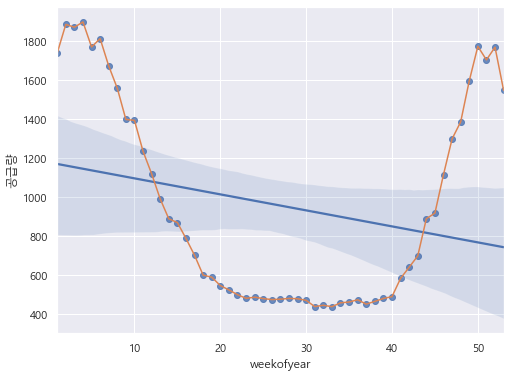

In [37]:
gb = train.groupby('weekofyear').mean()[['공급량']]
gb.reset_index(inplace=True)

plt.subplots(figsize=(8, 6))
sns.regplot(data=gb, x='weekofyear', y='공급량',)
sns.lineplot(data=gb, x='weekofyear', y='공급량')

<AxesSubplot:xlabel='weekofyear', ylabel='공급량'>

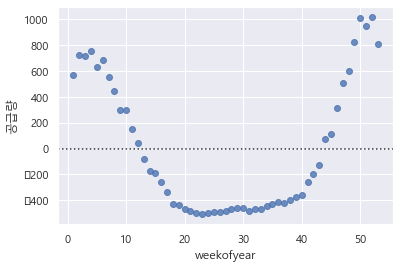

In [38]:
sns.residplot(data=gb, x='weekofyear', y='공급량')

<AxesSubplot:xlabel='weekofyear_new', ylabel='공급량'>

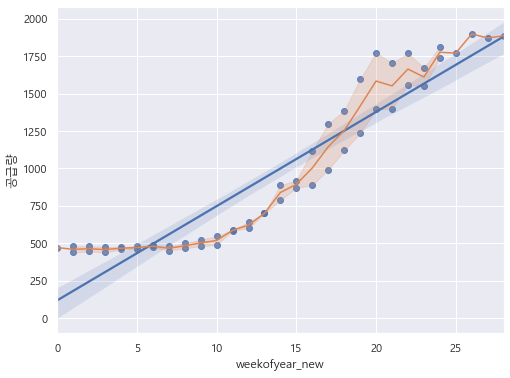

In [39]:
def applyWeekofyear(x):
    
    if x >= 30:
        result = x - 30
    elif (x < 30) & (x >= 2):
        result = - (x - 30)
    else:
        result = x + 23
    
    return result

gb['weekofyear_new'] = gb.apply(lambda x: applyWeekofyear(x['weekofyear']), axis=1)

plt.subplots(figsize=(8, 6))
sns.regplot(data=gb, x='weekofyear_new', y='공급량',)
sns.lineplot(data=gb, x='weekofyear_new', y='공급량')

<AxesSubplot:xlabel='weekofyear_new', ylabel='공급량'>

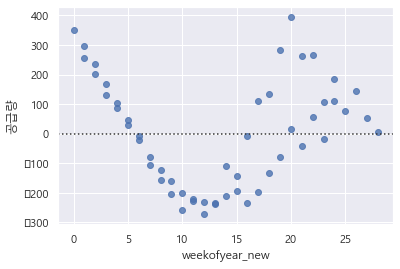

In [40]:
sns.residplot(data=gb, x='weekofyear_new', y='공급량')

<AxesSubplot:xlabel='weekday', ylabel='공급량'>

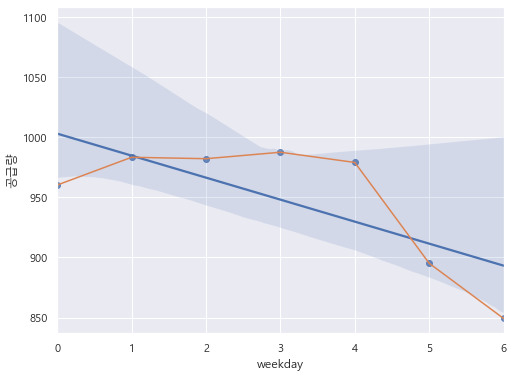

In [41]:
gb = train.groupby('weekday').mean()[['공급량']]
gb.reset_index(inplace=True)

plt.subplots(figsize=(8, 6))
sns.regplot(data=gb, x='weekday', y='공급량',)
sns.lineplot(data=gb, x='weekday', y='공급량')

<AxesSubplot:xlabel='weekday', ylabel='공급량'>

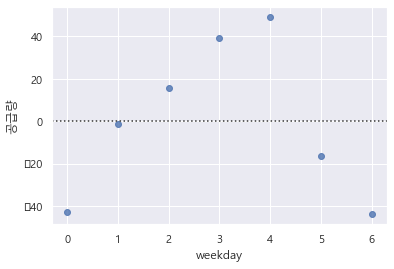

In [42]:
sns.residplot(data=gb, x='weekday', y='공급량')

<AxesSubplot:xlabel='weekday_new', ylabel='공급량'>

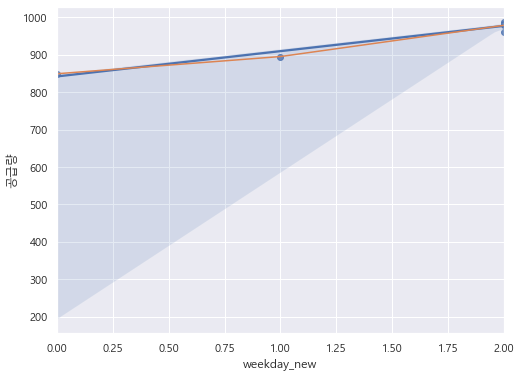

In [43]:
def applyWeekday(x):
    
    if x == 6:
        result = 0
    elif x == 5:
        result = 1
    else:
        result = 2
    
    return result

gb['weekday_new'] = gb.apply(lambda x: applyWeekday(x['weekday']), axis=1)

plt.subplots(figsize=(8, 6))
sns.regplot(data=gb, x='weekday_new', y='공급량',)
sns.lineplot(data=gb, x='weekday_new', y='공급량')

<AxesSubplot:xlabel='weekday_new', ylabel='공급량'>

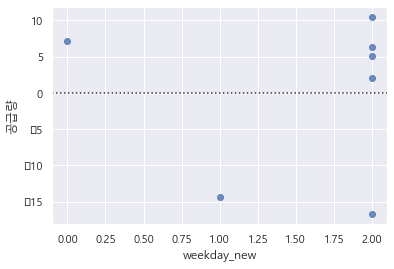

In [44]:
sns.residplot(data=gb, x='weekday_new', y='공급량')

<AxesSubplot:xlabel='시간', ylabel='공급량'>

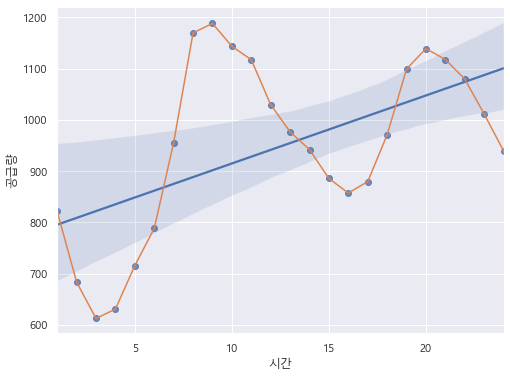

In [45]:
gb = train.groupby('시간').mean()[['공급량']]
gb.reset_index(inplace=True)

plt.subplots(figsize=(8, 6))
sns.regplot(data=gb, x='시간', y='공급량',)
sns.lineplot(data=gb, x='시간', y='공급량')

<AxesSubplot:xlabel='시간', ylabel='공급량'>

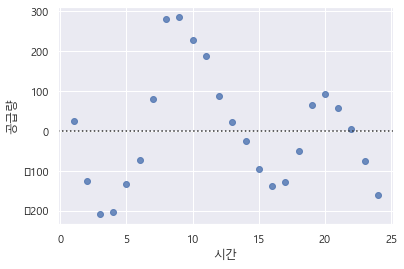

In [46]:
sns.residplot(data=gb, x='시간', y='공급량')

<AxesSubplot:xlabel='시간_new', ylabel='공급량'>

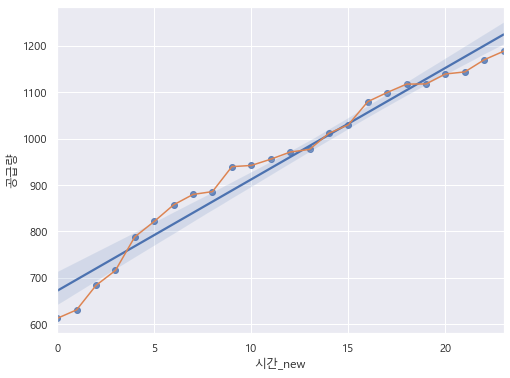

In [47]:
bins     = 24
sort_idx = gb.sort_values('공급량').index.to_numpy().reshape(-1, int(24 / bins))

for i in range(bins):
    gb.loc[gb['시간'].isin(sort_idx[i] + 1), '시간_new'] = i

plt.subplots(figsize=(8, 6))
sns.regplot(data=gb, x='시간_new', y='공급량',)
sns.lineplot(data=gb, x='시간_new', y='공급량')

<AxesSubplot:xlabel='시간_new', ylabel='공급량'>

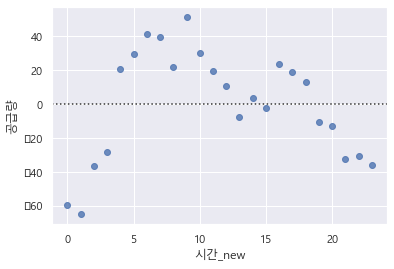

In [48]:
sns.residplot(data=gb, x='시간_new', y='공급량')

In [36]:
plt.figure(figsize=(12, 9))
sns.heatmap(total.corr(), annot=True)

NameError: name 'total' is not defined

<Figure size 864x648 with 0 Axes>

# train_val split

In [ ]:
total['year'].value_counts()

In [ ]:
train_years = [2013, 2014, 2015, 2016, 2017]
val_years   = [2018]

train = total[total['year'].isin(train_years)]
val   = total[total['year'].isin(val_years)]

In [ ]:
features = ['구분', 'month', 'day', 'weekday', '시간', 'temp_pca']

train_x = train[features]
train_y = train['공급량']
val_x   = val[features]
val_y   = val['공급량']

# corr

In [ ]:
features = ['구분', 'month', 'day', 'weekday', '시간', '공급량', 'temp_pca', 'year']

plt.figure(figsize=(12, 9))
sns.heatmap(train[features].corr(), annot=True); plt.show()

# train

In [ ]:
d_train = lgb.Dataset(train_x, train_y)
d_val   = lgb.Dataset(val_x, val_y)

params = {
    'objective': 'regression', 
    'metric': 'mae', 
    'seed': 42
}

model = lgb.train(
    params, d_train, 500, d_val, 
    verbose_eval=20, early_stopping_rounds=10, 
)

# sub

In [ ]:
features = ['구분', 'month', 'day', 'weekday', '시간', 'temp_pca']
test_x = test[features]

In [ ]:
preds = model.predict(test_x)

In [ ]:
preds

In [ ]:
sub['공급량'] = preds
sub

In [ ]:
# sub.to_csv('./sub/sub_00.csv', index=False)